In [2]:
import os
import h5py
import numpy as np
import math

from scipy.ndimage import median_filter, gaussian_filter, zoom
from skimage import exposure
from scipy.signal import fftconvolve
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from helpers import sech, normalize, ipf3D, convolution3D_FFTdomain, chiimg3D_FFT, findpeaks3D, pgrid3D, cidp23D

In [3]:
filePath = r"C:\Users\Lab User\Desktop\experiment data\07292025\Scan_4.hdf5"
dataPath = f'/RawData/Scan_4'

with h5py.File(filePath,'r') as f: 
    data = f[dataPath][()] # (slices, rows, width)
data = np.transpose(data,[1,2,0]) # (rows, width, slices)
dataCropped = data[150:1100,50:970,:]
cR, cW, cZ = np.shape(dataCropped)

In [5]:
highPct, medPct = 99, 95

# Apply median filter and threshold
threshHigh = np.percentile(dataCropped, highPct)
filteredData = median_filter(dataCropped, size=(3, 3, 3))
dataCropped[dataCropped > threshHigh] = filteredData[dataCropped > threshHigh]

# Update threshold and replace values above it with the median
threshHigh = np.percentile(dataCropped, highPct)
dataCropped[dataCropped > threshHigh] = np.mean(np.percentile(dataCropped, medPct))


In [6]:
meanPerCol = np.mean(dataCropped,axis=(1,2))
meanCenterRow = meanPerCol[math.floor(cR/2)]
scales = meanCenterRow/meanPerCol

dataColNorm = dataCropped*scales[:, np.newaxis, np.newaxis]
dataNorm = np.clip(exposure.rescale_intensity(dataColNorm, in_range='image', out_range=(0,1)), 0, 1)

blurred = gaussian_filter(dataNorm, sigma=3)
strength = 0.2
dataSharp = np.clip(dataNorm + strength * blurred, 0, 1)

Text(0.5, 1.0, 'Sharp')

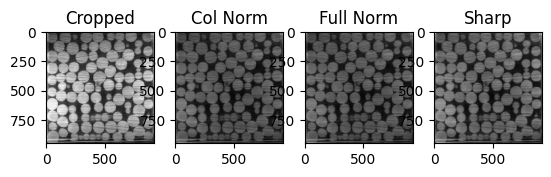

In [7]:
plt.subplot(1,4,1)
plt.imshow(dataCropped[:,:,math.floor(cZ/2)], cmap='grey')
plt.title('Cropped')

plt.subplot(1,4,2)
plt.imshow(dataColNorm[:,:,math.floor(cZ/2)], cmap='grey')
plt.title('Col Norm')

plt.subplot(1,4,3)
plt.imshow(dataNorm[:,:,math.floor(cZ/2)], cmap='grey')
plt.title('Full Norm')

plt.subplot(1,4,4)
plt.imshow(dataSharp[:,:,math.floor(cZ/2)], cmap='gray')
plt.title('Sharp')

In [8]:
from skimage.transform import probabilistic_hough_line
import cv2
from PIL import Image

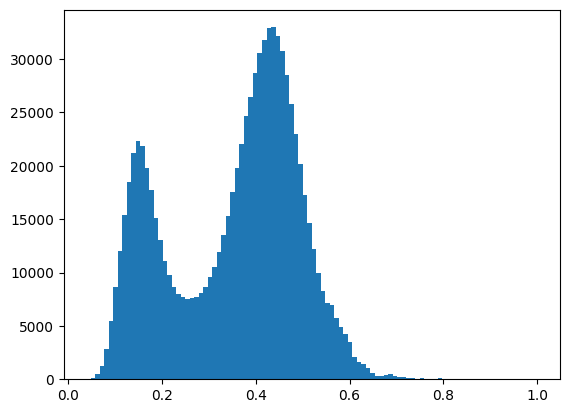

In [9]:
# Line finding using the Probabilistic Hough Transform
mid = dataSharp[:,:,math.floor(cZ/2)]
scaleFactor = 0.5
dataRescale = zoom(mid, scaleFactor, order=1)
plt.hist(mid.flatten(), bins=100)
plt.show()


In [10]:
midn = (mid*255).astype(np.uint8)
edges = cv2.Canny(midn, 0.1*255, 0.4*255)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from scipy.ndimage import maximum_filter

In [24]:
import numpy as np
from skimage.feature import canny
from skimage.util import img_as_ubyte
from scipy.ndimage import maximum_filter
from math import hypot, pi

def enhanced_circular_hough(img, min_r=10, max_r=60, step=2, sigma=2.75, threshold=100, dist_thresh=10):
    """
    Enhanced Circular Hough Transform with cross-radius maxima validation and distance filtering.
    
    Parameters:
    - img: 2D grayscale image
    - min_r, max_r, step: radius range and step
    - sigma: Canny edge detection smoothing parameter
    - threshold: minimum vote count for candidate circle
    - dist_thresh: minimum distance between accepted circles (safe house filter)
    
    Returns:
    - List of (x, y, r) tuples for detected circles
    """
    img = img_as_ubyte(img)
    edges = canny(img, sigma=sigma)
    h, w = edges.shape

    # Radius list
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    # Accumulator space
    accumulator = np.zeros((h, w, num_radii), dtype=np.uint64)

    # Precompute circle perimeter offsets for all radii
    circle_perimeters = {}
    theta = np.arange(0, 2 * pi, pi / 180)
    for r_index, r in enumerate(radii):
        dx = np.round(r * np.cos(theta)).astype(int)
        dy = np.round(r * np.sin(theta)).astype(int)
        circle_perimeters[r_index] = (dx, dy)

    # Edge coordinates
    y_idxs, x_idxs = np.nonzero(edges)

    # Voting in accumulator
    for r_index in range(num_radii):
        dx, dy = circle_perimeters[r_index]
        for x, y in zip(x_idxs, y_idxs):
            x_c = x - dx
            y_c = y - dy
            valid = (x_c >= 0) & (x_c < w) & (y_c >= 0) & (y_c < h)
            x_valid = x_c[valid].astype(int)
            y_valid = y_c[valid].astype(int)
            accumulator[y_valid, x_valid, r_index] += 1

    # Circle candidates list
    candidates = []

    # Detect local maxima in each radius layer and validate across neighboring radii
    for r_index in range(num_radii):
        acc_slice = accumulator[:, :, r_index]

        # Local maxima in 2D
        local_max = (maximum_filter(acc_slice, size=5) == acc_slice)
        candidate_mask = (acc_slice > threshold) & local_max
        coords = np.argwhere(candidate_mask)

        for y, x in coords:
            val = accumulator[y, x, r_index]
            # Cross-radius consistency check
            neighbors = []
            for offset in [-2, -1, 1, 2]:
                neighbor_idx = r_index + offset
                if 0 <= neighbor_idx < num_radii:
                    neighbors.append(accumulator[y, x, neighbor_idx])
            if all(val > n for n in neighbors):
                candidates.append((x, y, radii[r_index], val))

    # "Safe house" filtering to suppress nearby duplicates
    final_circles = []
    for x, y, r, val in sorted(candidates, key=lambda c: -c[3]):  # sort by vote count descending
        keep = True
        for fx, fy, fr in final_circles:
            if hypot(fx - x, fy - y) < dist_thresh:
                keep = False
                break
        if keep:
            final_circles.append((x, y, r))

    return final_circles

In [ ]:
# Run algorithm
circles = enhanced_circular_hough(image)

# Plot results
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

for x, y, r in circles:
    circle = plt.Circle((x, y), r, color='red', fill=False, linewidth=1.5)
    ax.add_patch(circle)

plt.title(f"Detected Circles: {len(circles)}")
plt.show()

In [23]:
img = img_as_ubyte(mid)
edges = canny(img, sigma=2.75)
h,w=edges.shape
threshold = 100

min_r,max_r,step = 10, 60, 2
radii = np.arange(min_r,max_r,step)
accumulator=np.zeros((h,w,len(radii)), dtype=np.uint64)

y_idxs,x_idxs=np.nonzero(edges)
for r_index, r in enumerate(radii):
    theta=np.arange(0,2*np.pi, np.pi/180)
    circle_perimeter = np.round(r*np.cos(theta)), np.round(r*np.sin(theta))
    dx,dy =circle_perimeter

    for (x,y) in zip(x_idxs,y_idxs):
        x_c=x-dx
        y_c=y-dy
        valid=(x_c>=0)&(x_c<w)&(y_c>=0)&(y_c<h)
        accumulator[y_c[valid].astype(int),x_c[valid].astype(int),r_index]+=1

circles=[]
for r_index, r in enumerate(radii):
    acc_slice = accumulator[:,:,r_index]
    local_max = maximum_filter(acc_slice, size=5) == acc_slice
    candidates = (acc_slice > threshold) & local_max
    max_points = np.argwhere(candidates)
    for y,x in max_points:
        circles.append((x,y,r))


NameError: name 'maximum_filter' is not defined

In [21]:
print(len(circles))

85


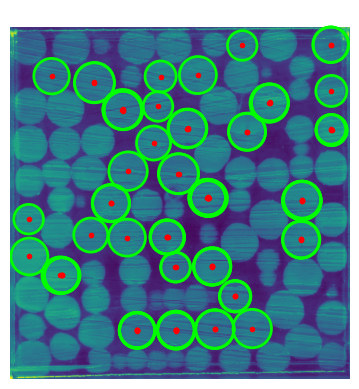

In [22]:
fig,ax=plt.subplots()
ax.imshow(img)

for (x,y,r) in circles:
    circle = plt.Circle((x,y),r,color='lime',fill=False,linewidth=2)
    ax.add_patch(circle)
    ax.plot(x,y,'ro',markersize=3)

plt.axis('off')
plt.show()


c:\Users\Lab User\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\image.py:183: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


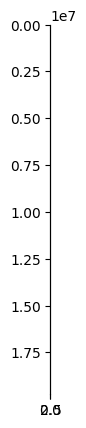

In [ ]:
plt.imshow(circles)

In [ ]:
cv2.imwrite("Dawg.pngs",circles)

error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


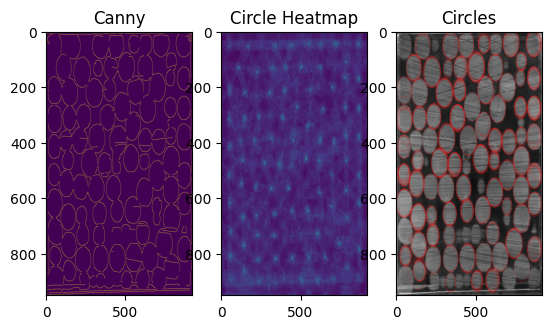

In [ ]:
# Load picture and detect edges
image = img_as_ubyte(mid)
edges = canny(image, sigma=2.75)

plt.subplot(1,3,1)
plt.imshow(edges, aspect=1.75)
plt.title('Canny')

hough_radii = np.arange(30, 60, 2)
hough_res = hough_circle(edges, hough_radii)

heatmap = hough_res.max(axis=0)
plt.subplot(1,3,2)
plt.imshow(heatmap, aspect=1.75)
plt.title('Circle Heatmap')

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,threshold=.25)

# Draw them
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (220, 20, 20)

plt.subplot(1,3,3)
plt.imshow(image, aspect=1.75)
plt.title('Circles')
plt.show()

#ax.imshow(image, cmap=plt.cm.gray)
#plt.show()

NameError: name 'cm' is not defined

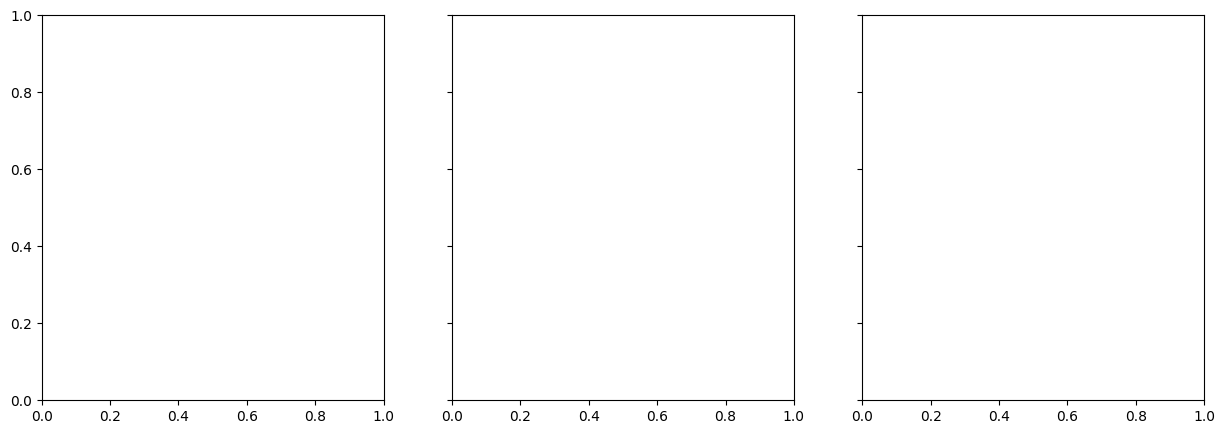

In [ ]:
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# Downsample
scaleFactor = 0.5
dataRescale = zoom(dataSharp, scaleFactor, order=1)

In [ ]:

# Particle detection

D, w = 100*scaleFactor, 2.5*scaleFactor
Cutoff, MinSep = 5, 75*scaleFactor
ss = int(2*(D/2 + 4*w/2)-1)
os = (ss-1)//2
xx, yy, zz = np.meshgrid(np.arange(-os,os+1), np.arange(-os,os+1), np.arange(-os,os+1), indexing='ij')
r = np.sqrt(xx**2 + yy**2 + zz**2)
ipi = ipf3D(r, D, w)
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
# Sub-voxel refinement
cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
ci = ipf3D(r_full, D, w)
di = ci - dataRescale
chi2 = np.sum(di**2)

nr, delchi2, mindelchi2, maxnr = 0, 1e99, 1, 5
while abs(delchi2)>mindelchi2 and nr<maxnr:
    dpx, dpy, dpz = cidp23D(cxyz, over, di, Np, D, w)
    px += dpx; py += dpy; pz += dpz
    cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
    r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
    ci = ipf3D(r_full, D, w)
    di = ci - dataRescale
    delchi2 = chi2 - np.sum(di**2)
    chi2 -= delchi2
    nr += 1

In [ ]:

# Visualization

# Max projection of residual
plt.figure()
plt.imshow(np.max(di**2, axis=2), cmap='gray', origin='lower')
plt.colorbar()
plt.title(f'Residual Chi^2 (max projection), Chi2={chi2:.2f}')
plt.show()

In [ ]:
# 3D scatter of particle centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px, py, pz, c='r', s=50)
ax.set_xlim(0, dataRescale.shape[1])
ax.set_ylim(0, dataRescale.shape[0])
ax.set_zlim(0, dataRescale.shape[2])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Detected particle centers')
plt.show()
